In [2]:
# solve imports and reload
import os
cwd = os.getcwd()
import sys
sys.path = [cwd] + sys.path
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np

# internal imports
import data
import visualization
import evaluation
import geometry
import graph_cuts
import utils

100%|██████████| 370/370 [00:01<00:00, 192.92it/s]


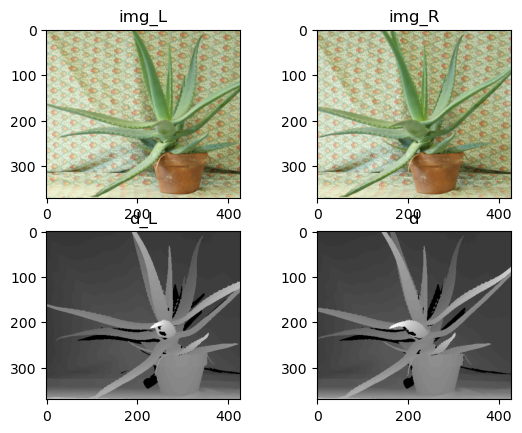

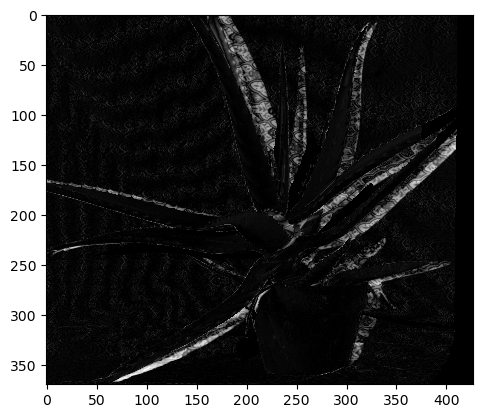

In [3]:
"""			3.1  Sanity Check			"""
# choose scene
chosen_scene = data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX]
# get images and gt disparities of scene
img_l, img_r = data.get_scene_images(chosen_scene)
d_l, d = data.get_scene_disparities(chosen_scene)
# visualize images and gt disparities
visualization.plot_scene(img_l, img_r, d_l, d)
# visualize a validation of gt disparities
differences_image = evaluation.get_disparity_rgb_distances(img_l, img_r, d)
visualization.plot_image(differences_image)

In [20]:
"""			3.2  3D Plot				"""
# extract constants
h, w = img_r.shape[:2]
x_0, y_0 = geometry.get_image_center(h=h, w=w)
# get camera matrices for the two views
P_r, K_r = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE,
										x_0=x_0, y_0=y_0)
P_l, K_l = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=0,
										x_0=x_0, y_0=y_0)
# calculate 3d points from the two views
points_r = geometry.get_3d_points_from_disparities(disparity_map=d,
												   focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE,
												   x_0=x_0, y_0=y_0,
												   right_image=True)
points_l = geometry.get_3d_points_from_disparities(disparity_map=d_l,
												   focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE,
												   x_0=x_0, y_0=y_0,
												   right_image=False)
points_all = np.concatenate((points_l.reshape(4, -1), points_r.reshape(4, -1)), axis=1)
point_colors_all = np.concatenate((img_l.reshape(-1, 3), img_r.reshape(-1, 3)), axis=0)
# plot the 3D points and the camera
utils.plot_cameras(P=np.stack((P_l, P_r), axis=0),
				   K=np.stack((K_l, K_r), axis=0),
				   X=points_all,
				   title="3.2_3D_plot_reconstruction",
				   point_colors=point_colors_all)


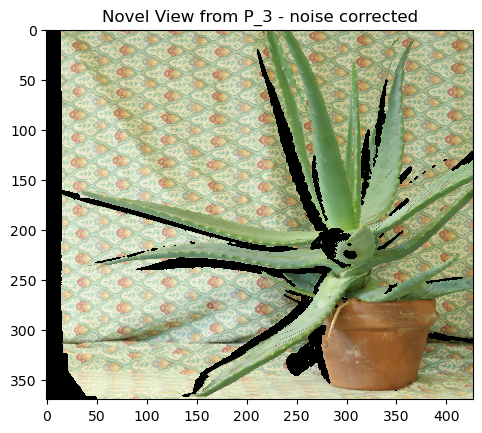

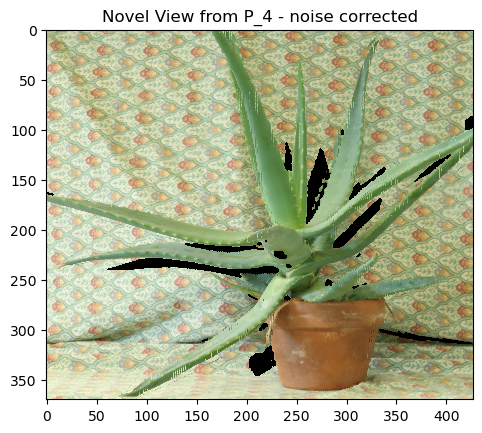

In [5]:
"""			3.3  Novel View				"""
# get camera matrices for the two views
P_3, K_3 = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=-data.BASELINE,
										x_0=x_0, y_0=y_0)
P_4, K_4 = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE/2,
										x_0=x_0, y_0=y_0)
# generate the novel view image
novel_image_3 = geometry.novel_view_image(points=points_all.reshape(4, -1), point_colors=point_colors_all.reshape(-1, 3),
										  P=P_3, h=h, w=w)
novel_image_4 = geometry.novel_view_image(points=points_all.reshape(4, -1), point_colors=point_colors_all.reshape(-1, 3),
										  P=P_4, h=h, w=w)
# clean the novel view image
cleaned_novel_image_3 = geometry.remove_black_stripes(novel_image_3)
cleaned_novel_image_4 = geometry.remove_black_stripes(novel_image_4)
# show the novel view image
visualization.plot_image(cleaned_novel_image_3 / 255, title="Novel View from P_3 - noise corrected")
visualization.plot_image(cleaned_novel_image_4 / 255, title="Novel View from P_4 - noise corrected")


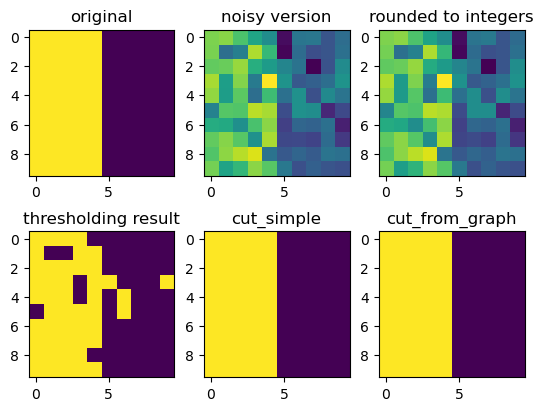

[[-23  -8   0]
 [ -8 -23  -8]
 [  0  -8 -23]]


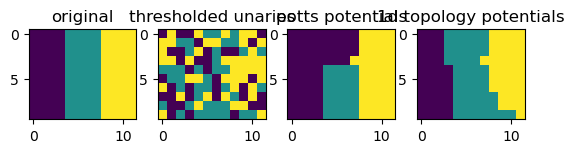

In [6]:
"""				4.1  PYGCO				"""
from pygco import cut_from_graph
import example


Scene Aloe:
accuracy = 5.01 
outlier_ration = 0.18


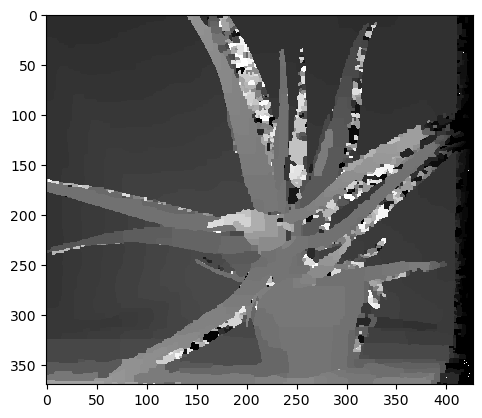

Scene Rocks1:


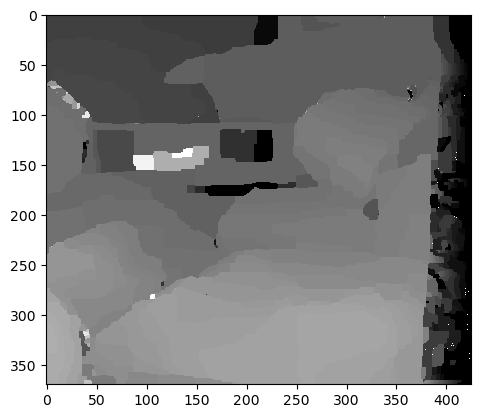

In [66]:
"""			4.2  Baseline solution		"""
K = 15
MAX_DEPTH_IN_IMAGE = 50

for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	print("Scene {0}:".format(scene))
	# read images of scene
	img_l, img_r = data.get_scene_images(scene)
	assert (img_l.shape == img_r.shape) and (len(img_l.shape) == 3) and (img_l.shape[-1] == 3)
	h, w, _ = img_l.shape

	# obtain disparity map using graph-cuts
	edges = graph_cuts.get_edges(height=h, width=w)
	pairwise_cost_mat = graph_cuts.pairwise_cost(K=K)
	unary_cost_mat = graph_cuts.unary_cost(right_image=img_r, left_image=img_l)
	disparity = cut_from_graph(edges=edges,
							   unary_cost=unary_cost_mat, #np.zeros((157990, 80), dtype=np.int32),
							   pairwise_cost=pairwise_cost_mat, #np.zeros((80, 80), dtype=np.int32),
							   algorithm="expansion")
	disparity = disparity.reshape(h, w)

	# calculate accuracy / outlier ratio if possible
	if scene in data.SCENES_WITH_GT_DISPARITIES:
		d_l, d = data.get_scene_disparities(scene)
		accuracy, outlier_ration = evaluation.evaluate_disparity(gt_disparity=d, pred_disparity=disparity)
		print("accuracy = {:.2f} \noutlier_ration = {:.2f}".format(accuracy, outlier_ration))

	# show disparity map
	visualization.plot_image(disparity)

	# calculate 3d points
	points_r = geometry.get_3d_points_from_disparities(disparity_map=disparity,
													   focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE,
													   x_0=x_0, y_0=y_0,
													   right_image=True)

	# filter out points that are not seen by the left camera / very far points
	mask = geometry.mask_for_3d_points(points_1=points_r, P_2=P_l, max_depth=MAX_DEPTH_IN_IMAGE, h=h, w=w)

	# plot the 3D points and the camera
	utils.plot_cameras(P=np.stack((P_l, P_r), axis=0),
					   K=np.stack((K_l, K_r), axis=0),
					   X=points_r.reshape(4, h*w)[:, mask.reshape(h*w)],
					   title="4.2_3D_plot_{scene}".format(scene=scene),
					   point_colors=img_r.reshape(h*w, 3)[mask.reshape(h*w)])